In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from tensorclass import TensorMultiModal
from distributions.toys import NGaussians, TwoMoons

def reshape_time_dim_like(t, state):
    if isinstance(t, (float, int)):
        return t
    else:
        return t.reshape(-1, *([1] * (state.ndim - 1)))

def display(state, num_points=None, ax=None, **kwargs):
    
    if num_points is None:
        num_points = len(state)
        
    ax.scatter(
        state.continuous.squeeze(1)[:num_points, 0],
        state.continuous.squeeze(1)[:num_points, 1],
        c=state.discrete.squeeze(1)[:num_points],
        **kwargs,
    )
    plt.xticks([])
    plt.yticks([])
    ax.axis("equal")

In [2]:
num_points = 10000

gauss = NGaussians(dim=2, vocab_size=8)
moons = TwoMoons(dim=2)

gauss_sample = gauss(num_points)
moon_sample = moons(num_points)

(
gauss_sample.continuous.shape, 
moon_sample.continuous.shape, 
gauss_sample.discrete.shape, 
moon_sample.discrete.shape
)

/home/df630/Multimodal-Bridges/multimodal_bridges/distributions/toys.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors = torch.tensor(labels[idx], dtype=torch.long)[:,None]


(torch.Size([10000, 1, 2]),
 torch.Size([10000, 1, 2]),
 torch.Size([10000, 1, 1]),
 torch.Size([10000, 1, 1]))

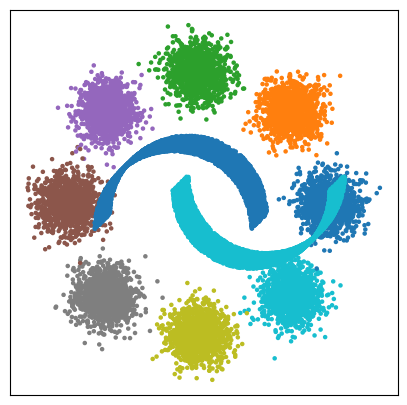

In [3]:
_, ax = plt.subplots(1, 1, figsize=(5, 5))

display(gauss_sample,  ax=ax, s=5, cmap="tab10")
display(moon_sample, ax=ax, s=5, cmap="tab10")

In [9]:
import torch
from torch import nn

class MultiModalMLP(nn.Module):
    """MLP architecture for hybrid continuous-discrete models"""

    def __init__(self, dim=2, vocab_size=8, dim_hidden=64):
        super().__init__()
        
        self.vocab_size = vocab_size
        
        # Embedding layer for discrete variables
        self.embed = nn.Embedding(vocab_size, dim_hidden // 4)

        # Multimodal body
        self.body = torch.nn.Sequential(
                    torch.nn.Linear(1 + dim + dim_hidden // 4, dim_hidden),
                    torch.nn.SELU(),
                    torch.nn.Linear(dim_hidden, dim_hidden),
                    torch.nn.SELU(),
                    torch.nn.Linear(dim_hidden, dim_hidden),
                    torch.nn.SELU(),
                    torch.nn.Linear(dim_hidden, dim_hidden),
                )
        
        # Heads
        self.continous_head = torch.nn.Linear(dim_hidden, dim)
        self.discrete_head = torch.nn.Linear(dim_hidden, vocab_size)

    def forward(self, state: TensorMultiModal):

        print(state.time.shape, state.continuous.shape, state.discrete.shape)
        print(self.embed(state.discrete).shape)
        
        h = torch.cat([state.time.squeeze(1), 
                       state.continuous.squeeze(1), 
                       self.embed(state.discrete).squeeze(1).squeeze(1)
                       ], dim=-1)    

        h = self.body(h) 
        x = self.continous_head(h)
        k = self.discrete_head(h)

        return TensorMultiModal(continuous=x, discrete=k)

MultiModalMLP()

MultiModalMLP(
  (embed): Embedding(8, 16)
  (body): Sequential(
    (0): Linear(in_features=19, out_features=64, bias=True)
    (1): SELU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SELU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): SELU()
    (6): Linear(in_features=64, out_features=64, bias=True)
  )
  (continous_head): Linear(in_features=64, out_features=2, bias=True)
  (discrete_head): Linear(in_features=64, out_features=8, bias=True)
)

In [10]:
import time
from datamodules.datasets import DataCoupling
from model.bridges import UniformLinearFlow, TelegraphBridge 
 
# data init
gaussians = NGaussians(dim=2, vocab_size=8)
moons = TwoMoons(dim=2)
batch_size = 256

# model init
bridge_continuous = UniformLinearFlow(sigma=0.01)
bridge_discrete = TelegraphBridge(gamma=0.1, vocab_size=8)
mse = torch.nn.MSELoss(reduce="mean")
cross_entropy = torch.nn.CrossEntropyLoss(reduce="mean")

# neural network init
model = MultiModalMLP(dim=2)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()

for k in range(20000):
    optimizer.zero_grad()

    # define source-target enpopints coupling
    source = gaussians(batch_size)
    target = moons(batch_size)
    batch = DataCoupling(source, target)

    # sample time and bridge state
    time = torch.rand((batch_size, 1, 1))
    continuous_state = bridge_continuous.sample(time, batch)
    discrete_state = bridge_discrete.sample(time, batch)
    multimodal_state = TensorMultiModal(time=time, 
                                        continuous=continuous_state, 
                                        discrete=discrete_state)

    # neural network forward pass
    heads = model(multimodal_state)

    # flow-matching loss for continuous state
    vt  = heads.continuous
    ut = bridge_continuous.drift(multimodal_state, batch)  # x1 - x0
    loss_continuous = mse(vt, ut)

    # markov jump classifier loss for discrete state
    # logits = heads.discrete
    # targets = batch.target.discrete
    # loss_discrete = cross_entropy(logits, targets)

    logits = heads.discrete.transpose(1, 2)
    targets = batch.target.discrete.squeeze(-1)
    loss_ce = cross_entropy(logits, targets.long()).unsqueeze(-1) 


    # combine total loss and optimize
    loss = loss_continuous + loss_discrete
    loss.backward()
    optimizer.step()

    if (k + 1) % 500 == 0:
        print(f"{k+1}: loss {loss.item():0.3f}")
                
        eps = 0
        steps = 100
        time_steps = torch.linspace(eps, 1.0 - eps, steps, device='cpu')
        delta_t = (time_steps[-1] - time_steps[0]) / (len(time_steps) - 1)

        state = gaussians(batch_size)

        for t in time_steps[1:]:
            state.time = torch.full((batch_size, 1), t.item(), device='cpu')
            heads = model(state)
            state = bridge_continuous.forward_step(state, heads, delta_t)
            state = bridge_discrete.forward_step(state, heads, delta_t)

        state.time = state.time.unsqueeze(1).repeat(1, state.shape[-1], 1)

        _, ax = plt.subplots(1, 1, figsize=(5, 5))
        display(gauss_sample,  ax=ax, s=5, cmap="tab10")


/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/df630/Multimodal-Bridges/multimodal_bridges/distributions/toys.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  colors = torch.tensor(labels[idx], dtype=torch.long)[:,None]


torch.Size([256, 1, 1]) torch.Size([256, 1, 2]) torch.Size([256, 1, 1])
torch.Size([256, 1, 1, 16])


/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([256, 1, 2])) that is different to the input size (torch.Size([256, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
def loss_fn(
        self, heads: TensorMultiModal, state: TensorMultiModal, batch: DataCoupling
    ) -> torch.Tensor:
        loss_continuous = torch.tensor(0.0, device=self.device)
        loss_discrete = torch.tensor(0.0, device=self.device)

        if heads.has_continuous:
            """mean square error loss for drift matching
            """

            vector = heads.continuous
            targets = self.bridge_continuous.drift(state, batch).to(self.device)

            loss_mse = self.loss_continuous_fn(vector, targets) * state.mask
            loss_continuous = loss_mse.sum() / state.mask.sum()

        if heads.has_discrete:
            """cross-entropy loss for discrete state classifier
            """

            logits = heads.discrete.transpose(1, 2)
            targets = batch.target.discrete.squeeze(-1).to(self.device)

            loss_ce = self.loss_discrete_fn(logits, targets.long()).unsqueeze(-1) * state.mask 
            loss_discrete = loss_ce.sum() / state.mask.sum()

        return loss_continuous, loss_discrete